In [1]:
import torch
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch.nn as nn
from torch import optim
from torch.autograd import Variable
import scipy.io as sio
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from torchvision import datasets, transforms
from tqdm import tqdm

In [2]:
import wandb

In [3]:
# download the cifar10 dataset

trainset = datasets.CIFAR10(root='/scratch/cifar10', train=True, download=True, transform=ToTensor())

Files already downloaded and verified


In [4]:
testset = datasets.CIFAR10(root='/scratch/cifar10', train=False, download=False, transform=ToTensor())

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [6]:
print(torch.version.cuda)
print(torch.__version__)

12.1
2.1.1+cu121


In [7]:
loaders = {
    'train': DataLoader(trainset, batch_size=256, shuffle=True, num_workers=1),
    'test': DataLoader(testset, batch_size=512, shuffle=False, num_workers=1)
}

In [8]:
class VGG16(nn.Module):
    def __init__(self, num_classes, batchnorm):
        super(VGG16, self).__init__()
        self.layer1 = self._make_layer(3, 64, batchnorm)
        self.layer2 = self._make_layer(64, 64, batchnorm, maxpool=True)
        self.layer3 = self._make_layer(64, 128, batchnorm)
        self.layer4 = self._make_layer(128, 128, batchnorm, maxpool=True)
        self.layer5 = self._make_layer(128, 256, batchnorm)
        self.layer6 = self._make_layer(256, 256, batchnorm)
        self.layer7 = self._make_layer(256, 256, batchnorm, maxpool=True)
        self.layer8 = self._make_layer(256, 512, batchnorm)
        self.layer9 = self._make_layer(512, 512, batchnorm)
        self.layer10 = self._make_layer(512, 512, batchnorm, maxpool=True)
        self.layer11 = self._make_layer(512, 512, batchnorm)
        self.layer12 = self._make_layer(512, 512, batchnorm)
        self.layer13 = self._make_layer(512, 512, batchnorm, maxpool=True)
        self.layer14 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(512, 4096),
            nn.ReLU(),
        )
        self.layer15 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
        )
        self.layer16 = nn.Sequential(
            nn.Linear(4096, num_classes),
        )

    def _make_layer(self, in_channels, out_channels, batchnorm, maxpool=False):
        layers = [
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=1),
        ]
        
        if batchnorm:
            layers.append(nn.BatchNorm2d(out_channels))
            
        layers.append(nn.ReLU())
        
        if maxpool:
            layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
            
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.layer9(out)
        out = self.layer10(out)
        out = self.layer11(out)
        out = self.layer12(out)
        out = self.layer13(out)
        out = out.view(out.size(0), -1)
        out = self.layer14(out)
        out = self.layer15(out)
        out = self.layer16(out)
        return out
   
    def fit(self, loaders, epochs, device, learning_rate):
        self.to(device)
        criterion = nn.CrossEntropyLoss().to(device)
        # adamoptimizer
        optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)

        loss_variation_list = []
        grad_norm_list = []
        smoothness_list = []
        steps = 0

        for epoch in range(epochs):
            self.train().to(device)

            total_loss = 0
            correct = 0
            total = 0

            for i, (images, labels) in enumerate(loaders['train']):
                self.train().to(device)
                optimizer.zero_grad()

                images = images.to(device)
                labels = labels.to(device)
                
                outputs = self(images)
                loss = criterion(outputs, labels)
                
                loss.backward()

                loss_variation = loss.item()
                grad_norm = 0.0
                for param in self.parameters():
                    grad_norm += param.grad.norm(2).item() ** 2
                    grad_norm = grad_norm ** 0.5

                optimizer.step()

                smoothness = grad_norm / loss_variation if loss_variation != 0 else float('inf')

                loss_variation_list.append(loss_variation)
                grad_norm_list.append(grad_norm)
                smoothness_list.append(smoothness)

                steps += 1

                total_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                    
            total_loss = total_loss / len(loaders['train'])
            accuracy = 100 * correct / total
            print('Epoch: {}, Loss: {:.4f}, Accuracy: {:.2f}%'.format(epoch + 1, total_loss, accuracy))

        return loss_variation_list, grad_norm_list, smoothness_list, steps

Epoch: 1, Loss: 1.4322, Accuracy: 46.23%
Epoch: 2, Loss: 0.9068, Accuracy: 67.83%
Epoch: 3, Loss: 0.6608, Accuracy: 77.02%
Epoch: 4, Loss: 0.4916, Accuracy: 83.26%
Epoch: 5, Loss: 0.3671, Accuracy: 87.62%
Epoch: 6, Loss: 0.2670, Accuracy: 91.13%
Epoch: 7, Loss: 0.2064, Accuracy: 93.14%
Epoch: 8, Loss: 0.1578, Accuracy: 94.73%
Epoch: 9, Loss: 0.1290, Accuracy: 95.69%
Epoch: 10, Loss: 0.1010, Accuracy: 96.66%
Epoch: 11, Loss: 0.0887, Accuracy: 97.03%
Epoch: 12, Loss: 0.0849, Accuracy: 97.29%
Epoch: 13, Loss: 0.0669, Accuracy: 97.89%
Epoch: 14, Loss: 0.0604, Accuracy: 98.01%
Epoch: 15, Loss: 0.0602, Accuracy: 97.97%
Epoch: 16, Loss: 0.0611, Accuracy: 97.99%
Epoch: 17, Loss: 0.0551, Accuracy: 98.21%
Epoch: 18, Loss: 0.0449, Accuracy: 98.56%
Epoch: 19, Loss: 0.0518, Accuracy: 98.28%
Epoch: 20, Loss: 0.0532, Accuracy: 98.24%
Epoch: 21, Loss: 0.0442, Accuracy: 98.54%
Epoch: 22, Loss: 0.0420, Accuracy: 98.65%
Epoch: 23, Loss: 0.0377, Accuracy: 98.85%
Epoch: 24, Loss: 0.0447, Accuracy: 98.60%
E

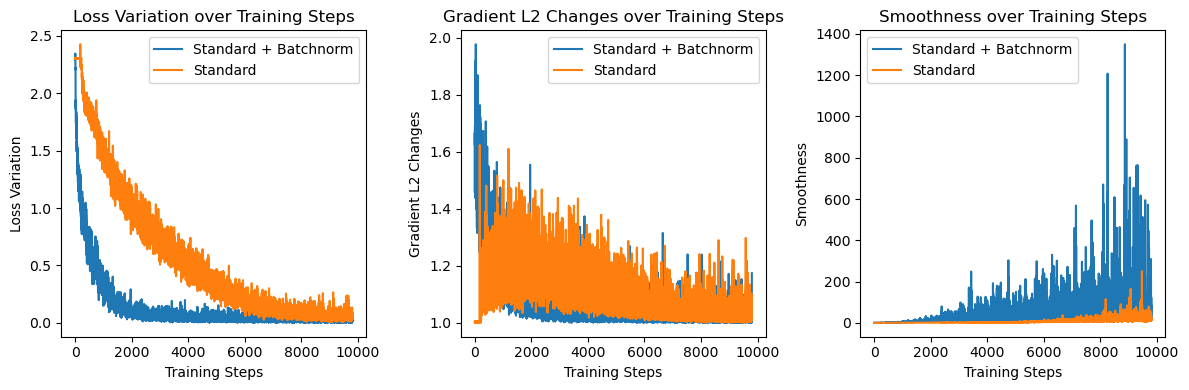

In [9]:
model = VGG16(10, True).to(device)
loss_variation_list, grad_norm_list, smoothness_list, steps = model.fit(loaders, epochs=50, device=device, learning_rate=0.0001)

model_nb = VGG16(10, False).to(device)
loss_variation_list_nb, grad_norm_list_nb, smoothness_list_nb, steps = model_nb.fit(loaders, epochs=50, device=device, learning_rate=0.0001)
epochs = range(1, steps+1)
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(epochs, loss_variation_list, label='Standard + Batchnorm')
plt.plot(epochs, loss_variation_list_nb, label='Standard')
plt.title('Loss Variation over Training Steps')
plt.xlabel('Training Steps')
plt.ylabel('Loss Variation')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(epochs, grad_norm_list, label='Standard + Batchnorm')
plt.plot(epochs, grad_norm_list_nb, label='Standard')
plt.title('Gradient L2 Changes over Training Steps')
plt.xlabel('Training Steps')
plt.ylabel('Gradient L2 Changes')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(epochs, smoothness_list, label='Standard + Batchnorm')
plt.plot(epochs, smoothness_list_nb, label='Standard')
plt.title('Smoothness over Training Steps')
plt.xlabel('Training Steps')
plt.ylabel('Smoothness')
plt.legend()

plt.tight_layout()
plt.show()
